In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib
import matplotlib.cm as cm
import os

### Config

In [2]:
folder_path = 'measurements/'
columns_to_keep = ['QPS', 'p95', 'target']
dfs = {}
grouped_dfs = {interference_type: [] for interference_type in ['cpu', 'l1d', 'l1i', 'l2', 'llc', 'membw', 'none']}

### Load Data

In [3]:
for file in os.listdir(folder_path):
    if file.endswith('.raw'):
        file_path = os.path.join(folder_path, file)
        parts = file.split('-')
        interference_type = parts[1]
        run_number = parts[2].split('.')[0]
        data = pd.read_csv(file_path, sep=r'\s+', usecols=columns_to_keep, skipfooter=2, engine='python')
        dfs[f'{interference_type}_{run_number}'] = data

### Plot 1

#### Chris' version (CCA guidelines)

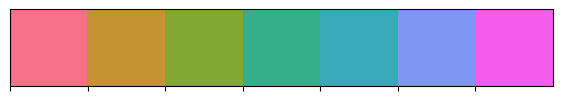

In [27]:
# try: deep, muted, bright, tab10, pastel, dark, colorblind, husl, hls
sns.palplot(sns.color_palette("deep", 7))

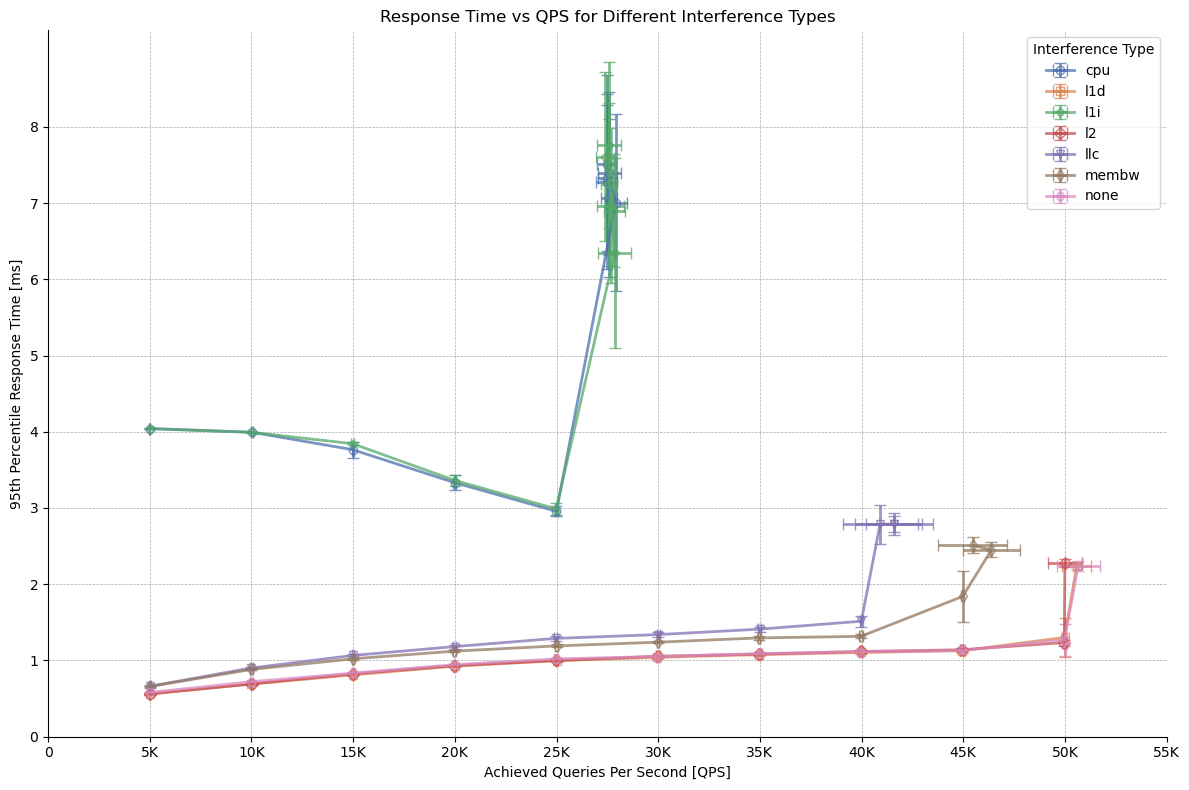

In [40]:
# Plot Style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
# Seaborn colors
colors = sns.color_palette("deep", 7)
ax.set_prop_cycle('color', colors)
markers = ['o-', 's-', 'p-', 'D-', 'v-', 'd-', 'H-']

for key in sorted(dfs.keys()):
    parts = key.split('_')
    interference_type = '_'.join(parts[:-1])
    run_number = parts[-1]
    
    if interference_type in grouped_dfs:
        grouped_dfs[interference_type].append(dfs[key])

for i, (interference_type, df_list) in enumerate(grouped_dfs.items()):
    p95_means = list()
    p95_stds = list()
    qps_means = list()
    qps_stds = list()
    
    target_qps_levels = df_list[0]['target'].values if df_list else []
    
    for target_qps in target_qps_levels:
        p95_values = [df[df['target'] == target_qps]['p95'].values[0] / 1000.0 for df in df_list]
        qps_values = [df[df['target'] == target_qps]['QPS'].values[0] / 1000.0 for df in df_list]
        
        p95_means.append(np.mean(p95_values))
        p95_stds.append(np.std(p95_values, ddof=1))
        qps_means.append(np.mean(qps_values))
        qps_stds.append(np.std(qps_values, ddof=1))
    
    ax.errorbar(qps_means, p95_means, xerr=qps_stds, yerr=p95_stds, fmt=markers[i], linewidth=2, 
                alpha=0.75, capsize=4, fillstyle="none", label=interference_type)

# Plot Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('white')
ax.legend(title='Interference Type')
x_labels = ['0', '5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '45K', '50K', '55K']
ax.set_xticks(range(0, 56, 5), x_labels)
y_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
ax.set_yticks(range(0, 9, 1), y_labels)
ax.grid(True, color='darkgrey', linestyle='--', linewidth=0.5)
ax.set_xlabel('Achieved Queries Per Second [QPS]')
ax.set_ylabel('95th Percentile Response Time [ms]')
ax.set_title('Response Time vs QPS for Different Interference Types')
fig.tight_layout()
if True:
    plt.show()
else:
    matplotlib.use("pgf")
    # swap pdflatex for tectonic based on your system
    plt.rc("pgf", texsystem="pdflatex", rcfonts=True)
    plt.rc("font", family="serif", size=11)
    plt.rc("text", usetex=True)
    plt.savefig("plots/plot1_CCA_guidelines.pgf", bbox_inches="tight")